<a href="https://colab.research.google.com/github/KonsumGandalf/proccessMining/blob/main/proccessMining/src/data/course_python_data/3_5PDQualityMetrics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%pip install pm4py

     |████████████████████████████████| 1.7 MB 5.3 MB/s 
     |████████████████████████████████| 40.6 MB 1.2 MB/s 
  Created wheel for stringdist: filename=StringDist-1.0.9-cp37-cp37m-linux_x86_64.whl size=23591 sha256=4cd89ec710681badf26543acc728e2519d770439be49574ee94c750998fb5f0b
  Stored in directory: /root/.cache/pip/wheels/d7/9c/d4/63bc3d8931de0980b9e4a724dea290bb40b8b1b2bd6227c8da
Successfully built stringdist


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
from scipy.stats import pareto

import pm4py
from pm4py.objects.log.util import dataframe_utils
from pm4py.objects.conversion.log import converter as log_converter

In [ ]:
# Load Event Log file in CSV

#log_csv = pd.read_csv('https://raw.githubusercontent.com/paoloceravolo/PM-Regensburg/main/CallCenterLog.csv', sep=',')
#log_csv = pd.read_csv('https://raw.githubusercontent.com/paoloceravolo/PM-Regensburg/main/reviewing.csv', sep=',')
log_csv = pd.read_csv('https://raw.githubusercontent.com/paoloceravolo/PM-Regensburg/main/ArtificialPatientTreatment.csv', sep=',')
log_csv = dataframe_utils.convert_timestamp_columns_in_df(log_csv)

#log_csv = log_csv.sort_values('Start Date')
#log_csv = log_csv.sort_values('Start Timestamp')
log_csv = log_csv.sort_values('datetime')

#log_csv.rename(columns={'Case ID': 'case:concept:name', 'Start Date': 'start_timestamp', 'End Date': 'time:timestamp', 'Activity': 'concept:name', 'Resource': 'org:resource'}, inplace=True) #change the name to a colum
#log_csv.rename(columns={'Case ID': 'case:concept:name', 'Start Timestamp': 'start_timestamp', 'Complete Timestamp': 'time:timestamp', 'Activity': 'concept:name', 'Resource': 'org:resource'}, inplace=True) #change the name to a colum
log_csv.rename(columns={'datetime': 'time:timestamp', 'patient': 'case:concept:name', 'action': 'concept:name', 'resource': 'org:resource'}, inplace=True)
parameters = {log_converter.Variants.TO_EVENT_LOG.value.Parameters.CASE_ID_KEY: 'case:concept:name'} # identify the case_id_key name (if not change it will simply be the mane of the coloumn)

# Covert the dataframe to an event log dictionary 

event_log = log_converter.apply(log_csv, parameters=parameters, variant=log_converter.Variants.TO_EVENT_LOG)

In [ ]:
filtered_log = pm4py.filter_case_size(event_log, 2, 10)
filtered_log = pm4py.filter_between(filtered_log, "Inbound Call", "Handle Case")
#print(filtered_log)

[{'attributes': {'concept:name': 'Case 3478'}, 'events': [{'concept:name': 'Inbound Call', 'start_timestamp': Timestamp('2010-03-18 17:19:00+0000', tz='UTC'), 'time:timestamp': Timestamp('2010-03-18 17:24:00+0000', tz='UTC'), 'Agent Position': 'BL', 'Customer ID': 'Customer 2898', 'Topic': 'Reservations Pro', 'Service Type': 'Referred to Servicer', 'org:resource': 'Steve'}, '..', {'concept:name': 'Handle Case', 'start_timestamp': Timestamp('2010-03-28 14:34:00+0000', tz='UTC'), 'time:timestamp': Timestamp('2010-03-28 14:35:00+0000', tz='UTC'), 'Agent Position': 'BL', 'Customer ID': 'Customer 2898', 'Topic': 'Reservations Pro', 'Service Type': 'Referred to Servicer', 'org:resource': 'Steve'}]}, '....', {'attributes': {'concept:name': 'Case 2973'}, 'events': [{'concept:name': 'Inbound Call', 'start_timestamp': Timestamp('2010-11-03 16:52:00+0000', tz='UTC'), 'time:timestamp': Timestamp('2010-11-03 16:58:00+0000', tz='UTC'), 'Agent Position': 'FL', 'Customer ID': 'Customer 2495', 'Topic':

In [ ]:
# Process Discovery

# process mining 
from pm4py.algo.discovery.alpha import algorithm as alpha_miner
from pm4py.algo.discovery.inductive import algorithm as inductive_miner
from pm4py.algo.discovery.heuristics import algorithm as heuristics_miner
from pm4py.algo.discovery.dfg import algorithm as dfg_discovery
from pm4py.algo.discovery.batches import algorithm 

# viz
from pm4py.visualization.petri_net import visualizer as pn_visualizer
from pm4py.visualization.process_tree import visualizer as pt_visualizer
from pm4py.visualization.heuristics_net import visualizer as hn_visualizer
from pm4py.visualization.dfg import visualizer as dfg_visualization

# misc 
from pm4py.objects.conversion.process_tree import converter as pt_converter

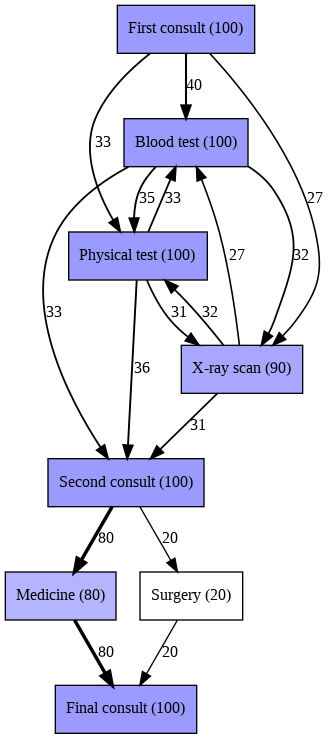

In [ ]:
# Create a Directly-follow Graph for Process Discovery
dfg = dfg_discovery.apply(event_log)
# Visualise
gviz = dfg_visualization.apply(dfg, log=event_log, variant=dfg_visualization.Variants.FREQUENCY)
dfg_visualization.view(gviz)

replaying log with TBR, completed variants ::   0%|          | 0/15 [00:00<?, ?it/s]

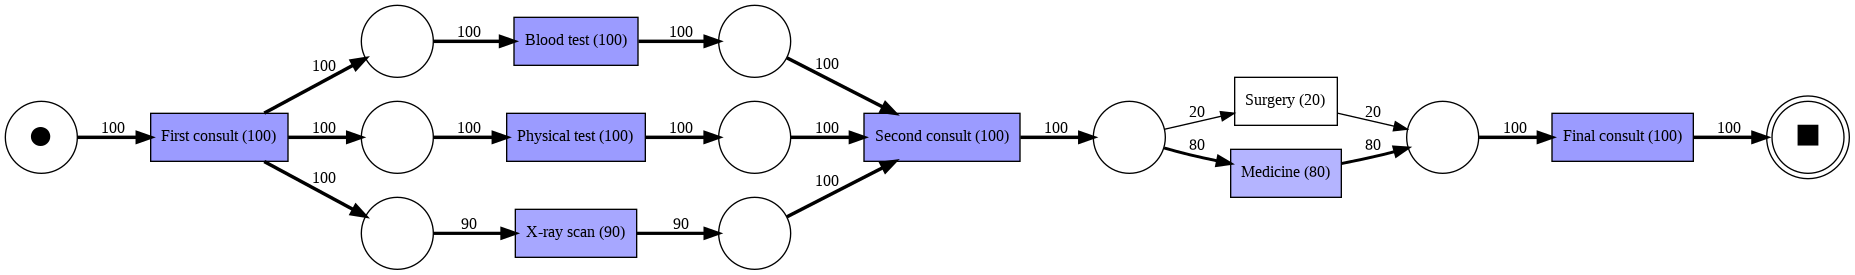

In [ ]:
# Discover a Petri Net using Alpha Miner
net, im, fm = alpha_miner.apply(event_log)
# Visualise 
gviz = pn_visualizer.apply(net, im, fm, variant=pn_visualizer.Variants.FREQUENCY, log=event_log)
pn_visualizer.view(gviz)

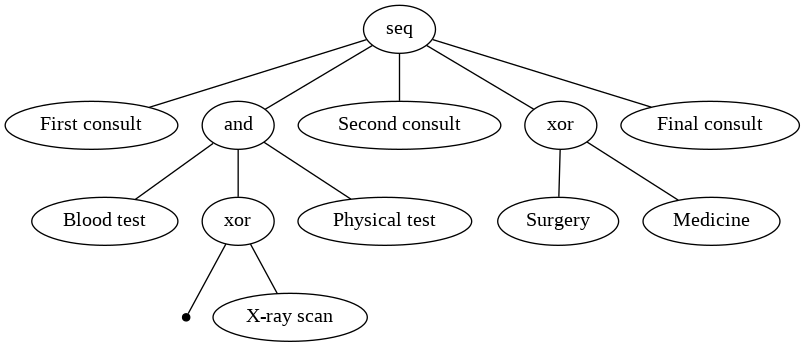

In [ ]:
# Discover process tree using inductive miner
tree = inductive_miner.apply_tree(event_log)
# Visualise
gviz = pt_visualizer.apply(tree, parameters={pt_visualizer.Variants.WO_DECORATION.value.Parameters.FORMAT: "png"})
pt_visualizer.view(gviz)

replaying log with TBR, completed variants ::   0%|          | 0/15 [00:00<?, ?it/s]

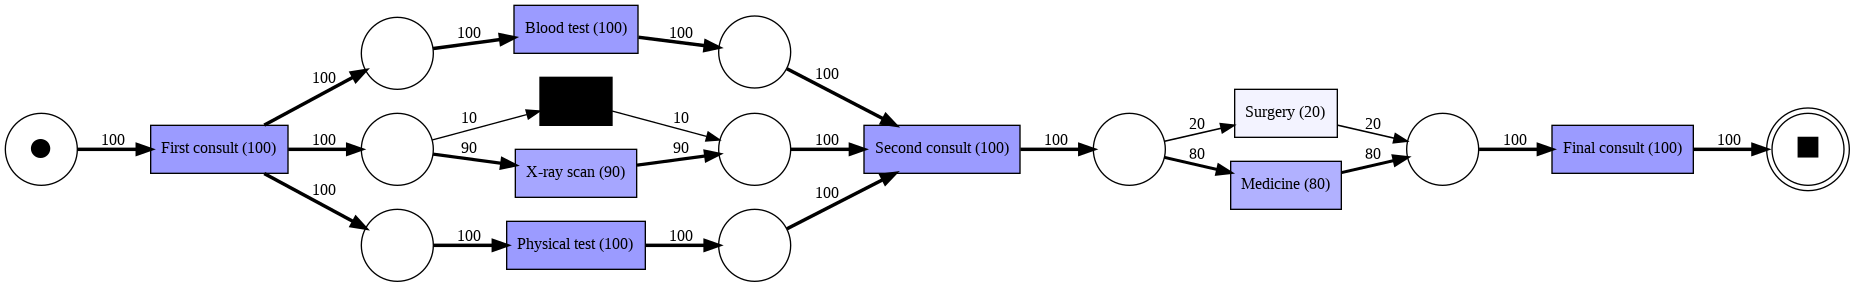

In [ ]:
# Convert process tree into a Petri Net
net, initial_marking, final_marking = pt_converter.apply(tree)
## Visualise
gviz = pn_visualizer.apply(net, initial_marking, final_marking, 
                           variant=pn_visualizer.Variants.FREQUENCY, 
                           log=event_log)
pn_visualizer.view(gviz)

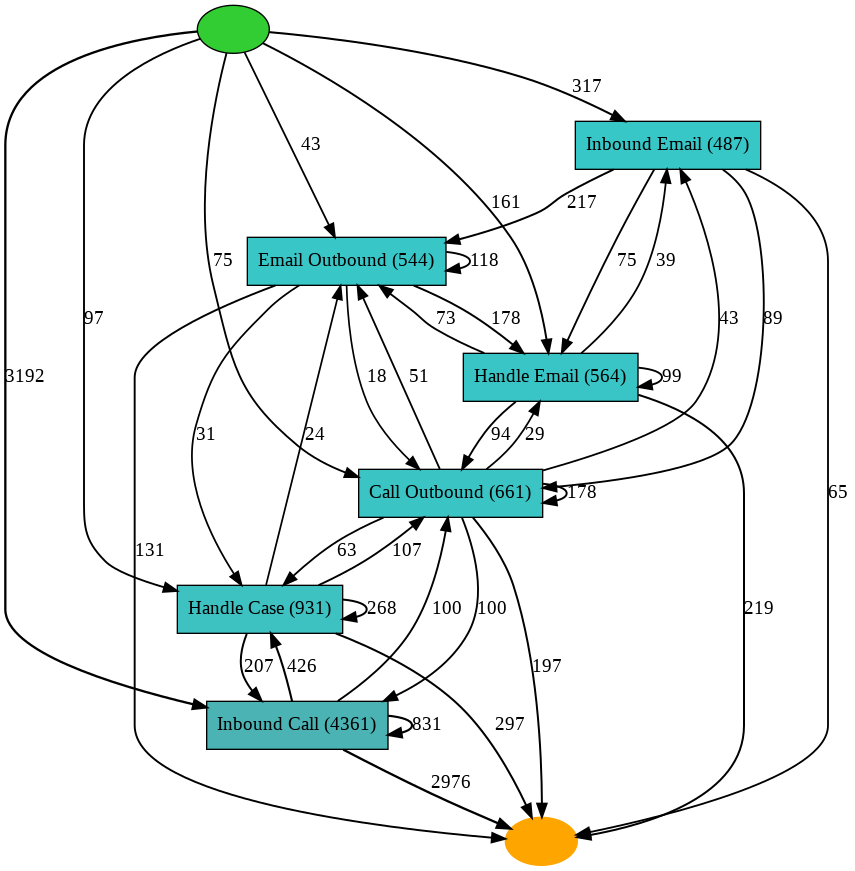

In [ ]:
# Discover an Heuristic Net using Heuristic Miner
parameters = {heuristics_miner.Variants.CLASSIC.value.Parameters.DEPENDENCY_THRESH: 0.6, heuristics_miner.Variants.CLASSIC.value.Parameters.MIN_ACT_COUNT: 30, heuristics_miner.Variants.CLASSIC.value.Parameters.MIN_DFG_OCCURRENCES: 30} 
heu_net = heuristics_miner.apply_heu(event_log, parameters=parameters)
# Visualise an Heuristic Net
gviz = hn_visualizer.apply(heu_net)
hn_visualizer.view(gviz)

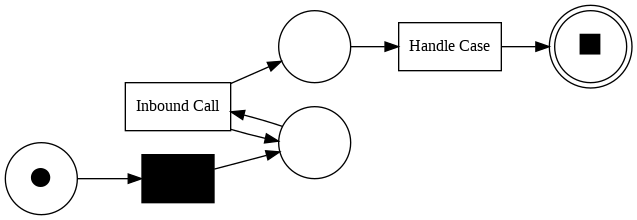

In [ ]:
# Discover a Petri Net using Heuristic Miner
parameters = {heuristics_miner.Variants.CLASSIC.value.Parameters.DEPENDENCY_THRESH: 0.6, heuristics_miner.Variants.CLASSIC.value.Parameters.MIN_ACT_COUNT: 30, heuristics_miner.Variants.CLASSIC.value.Parameters.MIN_DFG_OCCURRENCES: 30} 
net, im, fm = heuristics_miner.apply(event_log, parameters=parameters)
# Visualise a Petri Net
gviz = pn_visualizer.apply(net, im, fm)
pn_visualizer.view(gviz)

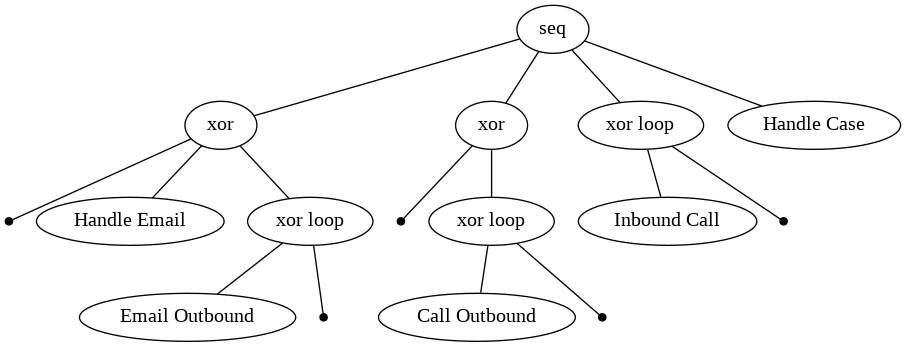

In [ ]:
# Discover process tree using Inductive Miner Infrequent
# Produces a more precise model, without fitness guarantees, by eliminating some behavior.
tree = inductive_miner.apply_tree(event_log, variant=inductive_miner.Variants.IMf, parameters={inductive_miner.Variants.IMf.value.Parameters.NOISE_THRESHOLD: 0.6})
# Visualise
gviz = pt_visualizer.apply(tree)
pt_visualizer.view(gviz)



replaying log with TBR, completed variants ::   0%|          | 0/16 [00:00<?, ?it/s]

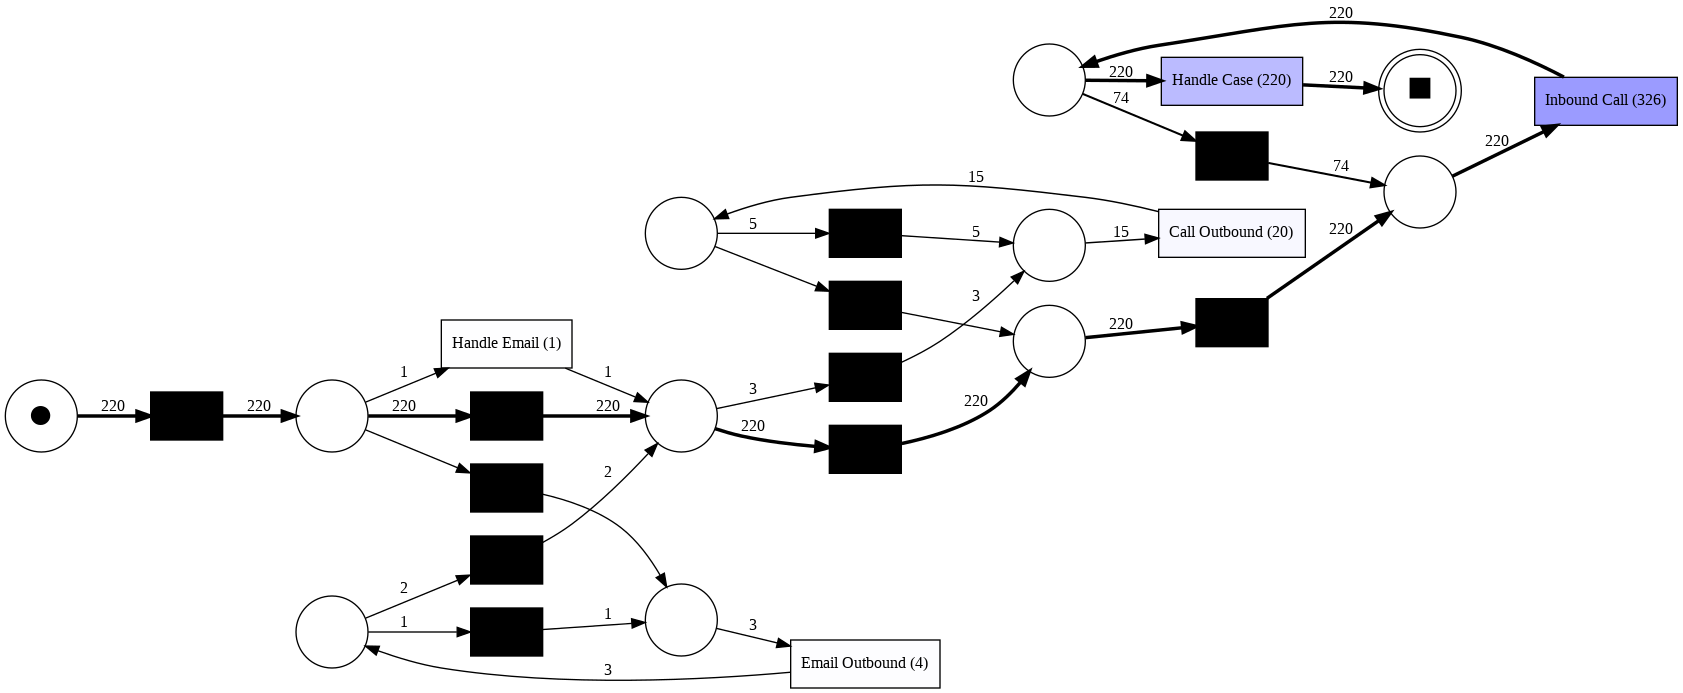

In [ ]:
# Convert process tree into a Petri Net
net, initial_marking, final_marking = pt_converter.apply(tree)
## Visualise
gviz = pn_visualizer.apply(net, initial_marking, final_marking, 
                           variant=pn_visualizer.Variants.FREQUENCY, 
                           log=event_log)
pn_visualizer.view(gviz)

In [ ]:
from pm4py.algo.evaluation.replay_fitness import algorithm as replay_fitness_evaluator
from pm4py.algo.evaluation.precision import algorithm as precision_evaluator
from pm4py.algo.evaluation.generalization import algorithm as generalization_evaluator
from pm4py.algo.evaluation.simplicity import algorithm as simplicity_evaluator

fitness = replay_fitness_evaluator.apply(event_log, net, im, fm, variant=replay_fitness_evaluator.Variants.TOKEN_BASED)
print('Fitness: ', fitness)

prec = precision_evaluator.apply(event_log, net, im, fm, variant=precision_evaluator.Variants.ETCONFORMANCE_TOKEN)
print('Precision: ', prec)

gen = generalization_evaluator.apply(event_log, net, im, fm)
print('Generalization: ', gen)

simp = simplicity_evaluator.apply(net)
print('Simplicity: ', simp)




replaying log with TBR, completed variants ::   0%|          | 0/404 [00:00<?, ?it/s]

Fitness:  {'perc_fit_traces': 0.0, 'average_trace_fitness': 0.1367278687746668, 'log_fitness': 0.3104773163883553, 'percentage_of_fitting_traces': 0.0}


replaying log with TBR, completed variants ::   0%|          | 0/813 [00:00<?, ?it/s]

Precision:  1.0


replaying log with TBR, completed variants ::   0%|          | 0/404 [00:00<?, ?it/s]

Generalization:  0.3555569752233514
Simplicity:  0.6444444444444444
